In [1]:
import feather
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import sparse

In [2]:
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.naive_bayes import ComplementNB, MultinomialNB

from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, Normalizer, QuantileTransformer

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, GroupKFold

from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix, classification_report, SCORERS

from sklearn.utils import shuffle

from sklearn.decomposition import TruncatedSVD

from scipy.stats import describe

In [3]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

## Load Sparse matrix

In [4]:
path = '../data/final/info_train.feather'
info_train = feather.read_dataframe(path)

path = '../data/final/info_test.feather'
info_test = feather.read_dataframe(path)

path = '../data/final/sparse_matrix_train.npz'
sparse_matrix_train = sparse.load_npz(path)

path = '../data/final/sparse_matrix_test.npz'
sparse_matrix_test = sparse.load_npz(path)

X_train = sparse_matrix_train
X_test = sparse_matrix_test

y_train = list(info_train['s_crsp_obj_cd'])
y_test = list(info_test['s_crsp_obj_cd'])

data_train = np.array(X_train.sum(1)).flatten()
data_test = np.array(X_test.sum(1)).flatten()

TOL = 300

index_train = np.abs(data_train) < TOL
index_test = np.abs(data_test) < TOL

X_train = X_train[index_train.T]
X_test = X_test[index_test.T]

y_train = list(d for d, s in zip(y_train, index_train) if s)
y_test = list(d for d, s in zip(y_test, index_test) if s)

info_train = info_train[index_train.T]
info_test = info_test[index_test.T]

X_total = sparse.vstack((X_train,X_test))
y_total = y_train + y_test

groups = info_train.groupby(['port_no']).ngroup()

print('Rows training: \n{:,} rows info\n{:,} rows data'.format(len(y_train),X_train.shape[0]))
print('')
print('Rows testing: \n{:,} rows info\n{:,} rows data'.format(len(y_test),X_test.shape[0]))
print('')
print('Total rows: {:,}'.format(X_train.shape[0] + X_test.shape[0]))

Rows training: 
33,976 rows info
33,976 rows data

Rows testing: 
15,993 rows info
15,993 rows data

Total rows: 49,969


## Scale data

In [637]:
scaler = StandardScaler(with_mean=False)

# Fit on training set only.
scaler.fit(X_train)

# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Models

## kMeans

In [19]:
%%time
print('Start kMeans...')
kmeans = KMeans(n_clusters=5,
                n_jobs=-1,
                random_state=0).fit(X_test)

Start kMeans...
CPU times: user 1min 22s, sys: 3.57 s, total: 1min 25s
Wall time: 1min 12s


In [18]:
kmeans.score()

TypeError: score() missing 1 required positional argument: 'X'

In [8]:
PAC_pred = PAC.predict(X_test)
print('PAC kappa score',cohen_kappa_score(PAC_pred, y_test))
print('PAC score',PAC.score(X_test, y_test))

NameError: name 'PAC' is not defined

## PassiveAggressiveClassifier

In [357]:
%%time
print('Start PassiveAggressiveClassifier...')
PAC = PassiveAggressiveClassifier(C = 1e-7,
                                  tol = 1e-5,
                                  n_iter_no_change=100,
                                  n_jobs = -1,
                                  early_stopping = True
                                  ).fit(X_train, y_train)

Start PassiveAggressiveClassifier...
CPU times: user 19.6 s, sys: 261 ms, total: 19.9 s
Wall time: 4.24 s


In [358]:
PAC_pred = PAC.predict(X_test)
print('PAC kappa score',cohen_kappa_score(PAC_pred, y_test))
print('PAC score',PAC.score(X_test, y_test))

PAC kappa score 0.6427706953883168
PAC score 0.7864690802225974


## Logistic regression

In [265]:
%%time
print('Start logistic regression...')
LR_1 = LogisticRegression(solver = 'saga',
                        multi_class = 'multinomial',
                        penalty = 'l2',
                        n_jobs = -1
                        ).fit(X_train, y_train)

Start logistic regression...


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CPU times: user 2min 1s, sys: 1min 41s, total: 3min 43s
Wall time: 1min 7s


In [261]:
LR_pred = LR_1.predict(X_test)
print('LR kappa score',cohen_kappa_score(LR_pred, y_test))
print('LR score',LR_1.score(X_test, y_test))

LR kappa score 0.6067931586609285
LR score 0.7687738385543675


## Random Forest

In [477]:
%%time
print('Start Random Forest...')
le = preprocessing.LabelEncoder()
le.fit(y_train)

y_train_rf = le.fit_transform(y_train)
y_test_rf = le.transform(y_test)

RF = RandomForestClassifier(n_estimators=1000, 
                            min_samples_leaf=100,
                            random_state=0,
                            max_features = "auto",
                            verbose = 1,
                            n_jobs = -1
                           ).fit(X_train, y_train_rf)

Start Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    9.0s


CPU times: user 30.7 s, sys: 6.69 s, total: 37.3 s
Wall time: 12.1 s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   11.6s finished


In [478]:
RF_pred = RF.predict(X_test)
print('RF kappa score',cohen_kappa_score(RF_pred, y_test_rf))
print('RF score',RF.score(X_test, y_test_rf))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


RF kappa score 0.15971443747508995


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    2.3s


RF score 0.5535546801725755


[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    2.9s finished


## SGD

In [681]:
%%time


# data has to be scaled!!!!

print('Start SGDClassifier...')

SGD = SGDClassifier(loss='log', 
                    penalty='l1', 
                    alpha=0.0001, 
                    l1_ratio=0.15,  
                    max_iter=1000, 
                    tol=None, 
                    verbose=0, 
                    n_jobs=-1, 
                    random_state=1, 
                    learning_rate='optimal', 
                    eta0=0.0, 
                    validation_fraction=0.1, 
                    n_iter_no_change=5, 
                    class_weight=None, 
                    warm_start=False, 
                    average=False, 
                    n_iter=None).fit(X_train, y_train_rf)

Start SGDClassifier...


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


CPU times: user 6min 17s, sys: 1.56 s, total: 6min 18s
Wall time: 1min 18s


In [682]:
SGD_pred = SGD.predict(X_test)
print('SGD kappa score',cohen_kappa_score(SGD_pred, y_test_rf))
print('SGD score',SGD.score(X_test, y_test_rf))

SGD kappa score 0.5409621188127545
SGD score 0.7134996560995436


In [683]:
%%time
PAC_pred = PAC.predict(X_test)
LR_pred = LR.predict(X_test)
RF_pred = RF.predict(X_test)

print('PAC kappa score',cohen_kappa_score(PAC_pred, y_test))
print('LR kappa score',cohen_kappa_score(LR_pred, y_test))
print('RF kappa score',cohen_kappa_score(RF_pred, y_test_rf))
print('')
print('PAC score',PAC.score(X_test, y_test))
print('LR score',LR.score(X_test, y_test))
print('RF score',RF.score(X_test, y_test_rf))
print('')

NameError: name 'LR' is not defined

# Analyse models

In [674]:
model = clf

In [643]:
info_test['new'] = model.predict(X_test)

NotFittedError: This GridSearchCV instance was initialized with refit=False. predict is available only after refitting on the best parameters. You can refit an estimator manually using the ``best_params_`` attribute

In [182]:
info_test.head(10)

,port_ID,port_no,report_dt,index_fund_flag,et_flag,crsp_obj_cd,mutual_fund,s_crsp_obj_cd,new
0,1028245-2010-06-30,1028245.0,2010-06-30,N,N,EDYG,Y,EDYG,EDYG
1,1028245-2010-07-31,1028245.0,2010-07-31,N,N,EDYG,Y,EDYG,EDYG
2,1028245-2010-08-31,1028245.0,2010-08-31,N,N,EDYG,Y,EDYG,EDYG
3,1028245-2010-09-30,1028245.0,2010-09-30,N,N,EDYG,Y,EDYG,EDYG
4,1028245-2011-02-28,1028245.0,2011-02-28,N,N,EDYG,Y,EDYG,EDYG
5,1028245-2011-03-31,1028245.0,2011-03-31,N,N,EDYG,Y,EDYG,EDYG
6,1028245-2011-04-30,1028245.0,2011-04-30,N,N,EDYG,Y,EDYG,EDYG
7,1028245-2011-05-31,1028245.0,2011-05-31,N,N,EDYG,Y,EDYG,EDYG
8,1028245-2011-06-30,1028245.0,2011-06-30,N,N,EDYG,Y,EDYG,EDYG
9,1028245-2011-08-31,1028245.0,2011-08-31,N,N,EDYG,Y,EDYG,EDYG


In [228]:
prob_pos = model.predict_proba(X_test)

AttributeError: 'PassiveAggressiveClassifier' object has no attribute 'predict_proba'

In [675]:
pred_label = model.predict(X_test)

ValueError: X has 2382968 features per sample; expecting 100

In [676]:
print(model.classes_)

['EDYB' 'EDYG' 'EDYH' 'EDYI' 'EDYS']


In [677]:
cm = confusion_matrix(y_test, pred_label, labels=model.classes_)
print(cm)

[[7141  545   28    9    0]
 [ 339 5665   68    3    0]
 [  34  266 1105   10    0]
 [   7  404    1  368    0]
 [   0    0    0    0    0]]


In [678]:
#np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
print(np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],2))

[[0.92 0.07 0.   0.   0.  ]
 [0.06 0.93 0.01 0.   0.  ]
 [0.02 0.19 0.78 0.01 0.  ]
 [0.01 0.52 0.   0.47 0.  ]
 [ nan  nan  nan  nan  nan]]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [679]:
print(classification_report(y_test, pred_label))

              precision    recall  f1-score   support

        EDYB       0.95      0.92      0.94      7723
        EDYG       0.82      0.93      0.87      6075
        EDYH       0.92      0.78      0.84      1415
        EDYI       0.94      0.47      0.63       780

   micro avg       0.89      0.89      0.89     15993
   macro avg       0.91      0.78      0.82     15993
weighted avg       0.90      0.89      0.89     15993



# CV Grid search

# ToDo: CV not stratified

### Model

In [662]:
model_grid_cv = LogisticRegression(random_state=1)

model_grid_cv = PassiveAggressiveClassifier(random_state=1)

In [668]:
group_kfold = GroupKFold(n_splits=5)
cv = group_kfold.split(X_train, y_train, groups)

tuned_parameters_PAC = {'C': [1e-6], 'tol':[1e-5],'n_iter_no_change':[20]}

tuned_parameters_LR = {'solver': ['saga'],
                       'multi_class':['multinomial'],
                       'penalty':['l2']}

scoring = 'f1_micro'

clf = GridSearchCV(model_grid_cv, 
                   tuned_parameters_PAC, 
                   cv = group_kfold.split(X_train, y_train, groups), 
                   n_jobs=-1, 
                   verbose=10, 
                   refit = True,
                   scoring=scoring, 
                   return_train_score=True)

In [669]:
%%time
clf.fit(X_train_svd, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   44.2s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   45.4s remaining:   30.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.4s finished


CPU times: user 43.8 s, sys: 238 ms, total: 44 s
Wall time: 1min 29s


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


GridSearchCV(cv=<generator object _BaseKFold.split at 0x1937d40c0>,
       error_score='raise-deprecating',
       estimator=PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
              early_stopping=False, fit_intercept=True, loss='hinge',
              max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
              random_state=1, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1e-06], 'tol': [1e-05], 'n_iter_no_change': [20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_micro', verbose=10)

In [670]:
results = clf.cv_results_
test_score_mean = results['mean_test_score']
train_score_mean = results['mean_train_score']
test_std_mean = results['std_test_score']
train_std_mean = results['std_train_score']

for mean, std, params in zip(test_score_mean, test_std_mean, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

0.675 (+/-0.029) for {'C': 1e-06, 'n_iter_no_change': 20, 'tol': 1e-05}


In [672]:
for mean, std, params in zip(train_score_mean, train_std_mean, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

0.728 (+/-0.006) for {'C': 1e-06, 'n_iter_no_change': 20, 'tol': 1e-05}


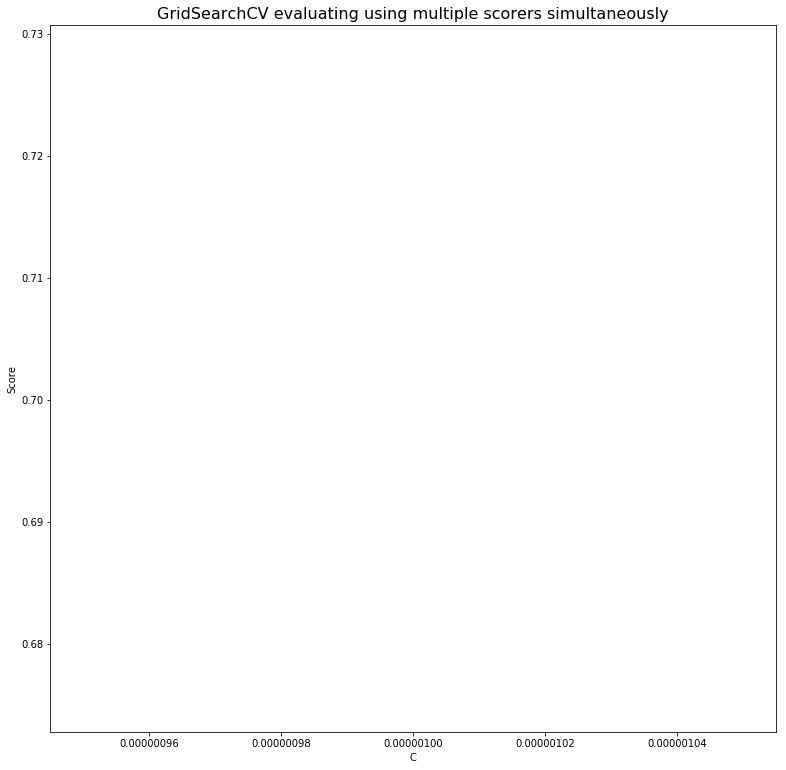

In [673]:
X_axis = np.array(results['param_C'].data, dtype=float)

plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("C")
plt.ylabel("Score")

ax = plt.gca()
ax.plot(X_axis, test_score_mean)
ax.plot(X_axis, train_score_mean)

# ax.set_xlim(0, 402)
# ax.set_ylim(0.73, 1)
# plt.legend(loc="best")
plt.grid(False)
plt.show()

## TruncatedSVD


In [648]:
%%time
svd = TruncatedSVD(n_components=200, n_iter=7, random_state=42)
svd.fit(X_train)  

CPU times: user 10min 48s, sys: 1min 36s, total: 12min 24s
Wall time: 5min 32s


In [649]:
print(svd.explained_variance_ratio_)  
print()
print('Total variance explained: {:.3f}%'.format(svd.explained_variance_ratio_.sum()*100))

[0.05732203 0.0490014  0.04685699 0.04448169 0.03386874 0.03088257
 0.02926858 0.02341689 0.0205486  0.01520279 0.01534676 0.01385962
 0.01369498 0.01352908 0.01257042 0.01032802 0.00854272 0.00562977
 0.00820486 0.00778515 0.00754215 0.00749358 0.00737984 0.00717312
 0.00717636 0.00696069 0.00673315 0.00668851 0.00673532 0.0060985
 0.00570812 0.00552525 0.00502403 0.00474178 0.00475578 0.00475045
 0.00467259 0.00461688 0.00461933 0.00449155 0.0044872  0.00447206
 0.00430706 0.00429661 0.00423373 0.00423688 0.004191   0.0039954
 0.00383804 0.0037967  0.00378657 0.00368497 0.00368034 0.00367714
 0.00351813 0.00347585 0.00338247 0.00328443 0.00327946 0.00327299
 0.00320901 0.00319275 0.00318978 0.00317044 0.00309208 0.00307371
 0.00305232 0.00290927 0.00287883 0.00287015 0.00277535 0.00273268
 0.00254437 0.00247634 0.00244279 0.00237847 0.00236887 0.00224856
 0.00222021 0.0022139  0.00212974 0.00205375 0.00202687 0.00198772
 0.00186165 0.00181484 0.00177105 0.00173004 0.00167659 0.001673

In [629]:
X_train_svd = svd.transform(X_train)
X_test_svd = svd.transform(X_test)

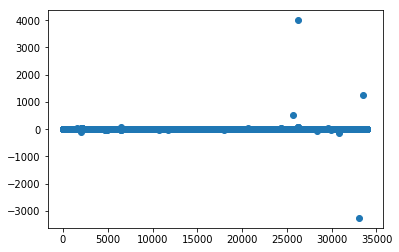

In [385]:
plt.plot(X_train_svd[:,8],'o')

In [650]:
df = pd.DataFrame(X_train_svd)
df['class'] = y_train

In [651]:
groups = df.groupby('class')

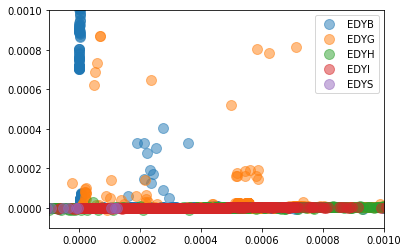

In [659]:
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.iloc[:,0], group.iloc[:,1], marker='o', linestyle='', ms=10, label=name, alpha=0.5)
    plt.xlim(-0.0001, 0.001)
    plt.ylim(-0.0001, 0.001)
    ax.legend(numpoints=1)

# Visual analysis of sample data

In [458]:
data = X_total.sum(1)

In [466]:
index = np.abs(data) < 3000
y = data[index].T

In [467]:
sum(index == False)

matrix([[0]])

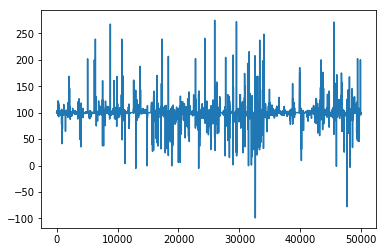

In [468]:
plt.plot(y)

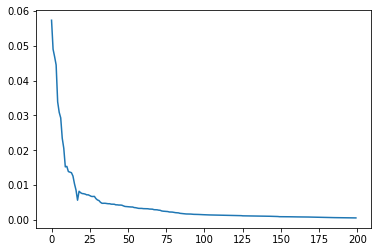

In [680]:
plt.plot(svd.explained_variance_ratio_)